In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import re
import wandb

from data import WordSequenceDataset
from model import EncoderOnlyNextTokenPredictor

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\\s]", "", text)  
    return text

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 100
learning_rate = 1e-3
window_size = 3
max_vocab_size = 50

In [4]:
dataset = WordSequenceDataset("data/simple_corpus.txt", window_size=window_size, max_vocab_size=max_vocab_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[DEBUG] final samples : 1704


In [5]:
print("# of vocabs", dataset.vocab_size)
print("Top 20 vocabs:", list(dataset.token2idx.keys())[2:22])

# of vocabs 50
Top 20 vocabs: ['not', 'do', 'they', 'you', 'we', 'i', 'he', 'she', 'want', 'to', 'hate', 'a', 'eat', 'like', 'prefer', 'need', 'drink', 'love', 'pizza', 'burger']


### Dataset & Dataloader

### Model setup

In [6]:
model = EncoderOnlyNextTokenPredictor(vocab_size=dataset.vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Loop

In [7]:
wandb.finish()

In [8]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
wandb.init(project="embedding-visualization", config={
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "window_size": window_size,
    "max_vocab_size": max_vocab_size
})

wandb: Currently logged in as: cikciki98 (cikciki98-yonsei-university). Use `wandb login --relogin` to force relogin


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd6c83d6230, execution_count=9 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd6c83d5330, raw_cell="wandb.init(project="embedding-visualization", conf.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X14sdnNjb2RlLXJlbW90ZQ%3D%3D> result=<wandb.sdk.wandb_run.Run object at 0x7fd35ca2a0e0>>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [10]:
wandb.watch(model.token_embedding, log="all", log_freq=10)

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        grad_norm = torch.norm(model.token_embedding.embedding.weight.grad)
        wandb.log({"embedding_grad_norm": grad_norm.item()})

        embedding_weights = model.token_embedding.embedding.weight.detach().cpu().numpy()
        wandb.log({
            "embedding_weights_step": wandb.Histogram(embedding_weights.flatten())
        })

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    wandb.log({"loss": avg_loss, "epoch": epoch})


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd35ca4f820, raw_cell="wandb.watch(model.token_embedding, log="all", log_.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X15sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Epoch 1: Loss = 2.9620
Epoch 2: Loss = 1.9155
Epoch 3: Loss = 1.6270
Epoch 4: Loss = 1.5840
Epoch 5: Loss = 1.5526
Epoch 6: Loss = 1.5389
Epoch 7: Loss = 1.5482
Epoch 8: Loss = 1.5301
Epoch 9: Loss = 1.5284
Epoch 10: Loss = 1.5164
Epoch 11: Loss = 1.5288
Epoch 12: Loss = 1.5298
Epoch 13: Loss = 1.5219
Epoch 14: Loss = 1.5286
Epoch 15: Loss = 1.5189
Epoch 16: Loss = 1.5178
Epoch 17: Loss = 1.5211
Epoch 18: Loss = 1.5108
Epoch 19: Loss = 1.5059
Epoch 20: Loss = 1.5084
Epoch 21: Loss = 1.5125
Epoch 22: Loss = 1.5141
Epoch 23: Loss = 1.5009
Epoch 24: Loss = 1.5041
Epoch 25: Loss = 1.5174
Epoch 26: Loss = 1.4999
Epoch 27: Loss = 1.4994
Epoch 28: Loss = 1.4954
Epoch 29: Loss = 1.5039
Epoch 30: Loss = 1.4953
Epoch 31: Loss = 1.5096
Epoch 32: Loss = 1.5063
Epoch 33: Loss = 1.5101
Epoch 34: Loss = 1.5098
Epoch 35: Loss = 1.5014
Epoch 36: Loss = 1.5018
Epoch 37: Loss = 1.5105
Epoch 38: Loss = 1.5086
Epoch 39: Loss = 1.4920
Epoch 40: Loss = 1.5012
Epoch 41: Loss = 1.5066
Epoch 42: Loss = 1.4989
E

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

### Non-contextual visualization

In [11]:
def visualize_token_embeddings(model, idx2token):
    emb = model.token_embedding.embedding.weight.detach().cpu().numpy()
    reduced = TSNE(n_components=2, perplexity=5).fit_transform(emb)

    plt.figure(figsize=(8, 6))
    for i, label in idx2token.items():
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=12)
    plt.title("Non-Contextual Token Embedding")
    plt.grid(True)
    plt.show()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd35c189ba0, raw_cell="def visualize_token_embeddings(model, idx2token):
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X20sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd35c189bd0, execution_count=11 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd35c189ba0, raw_cell="def visualize_token_embeddings(model, idx2token):
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X20sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd2fe5ff880, raw_cell="visualize_token_embeddings(model, dataset.idx2toke.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X21sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


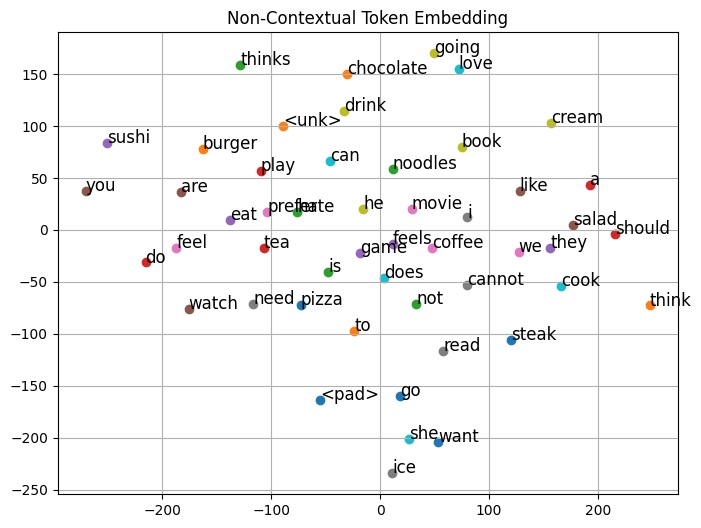

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd2fe5ffc40, execution_count=12 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd2fe5ff880, raw_cell="visualize_token_embeddings(model, dataset.idx2toke.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X21sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [12]:
visualize_token_embeddings(model, dataset.idx2token)

### Contextual Embedding

In [13]:
def extract_contextual_embeddings(model, sentence, token2idx):
    model.eval()
    tokens = sentence.split()
    idxs = [token2idx.get(tok, 1) for tok in tokens]  # 1 is <unk>
    x = torch.tensor([idxs]).to(device)

    with torch.no_grad():
        tok_emb = model.token_embedding(x)
        pos_emb = model.pos_embedding(x)
        x = tok_emb + pos_emb
        for layer in model.encoder_layers:
            x = layer(x)
        x = model.norm(x)
        return x.squeeze(0).cpu().numpy(), tokens

def visualize_contextual_embeddings(model, token2idx, sentences):
    vectors = []
    labels = []
    for sentence in sentences:
        vecs, toks = extract_contextual_embeddings(model, sentence, token2idx)
        vectors.extend(vecs)
        labels.extend([f"{tok} ({sentence})" for tok in toks])

    reduced = TSNE(n_components=2, perplexity=3).fit_transform(np.array(vectors))

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=10)
    plt.title("Contextual Embeddings by Sentence")
    plt.grid(True)
    plt.show()


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd35c189ba0, raw_cell="def extract_contextual_embeddings(model, sentence,.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X23sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd486687f10, execution_count=13 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd35c189ba0, raw_cell="def extract_contextual_embeddings(model, sentence,.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X23sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd48667d960, raw_cell="sentences = ["He plays game", "He is tired"]
visua.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X24sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


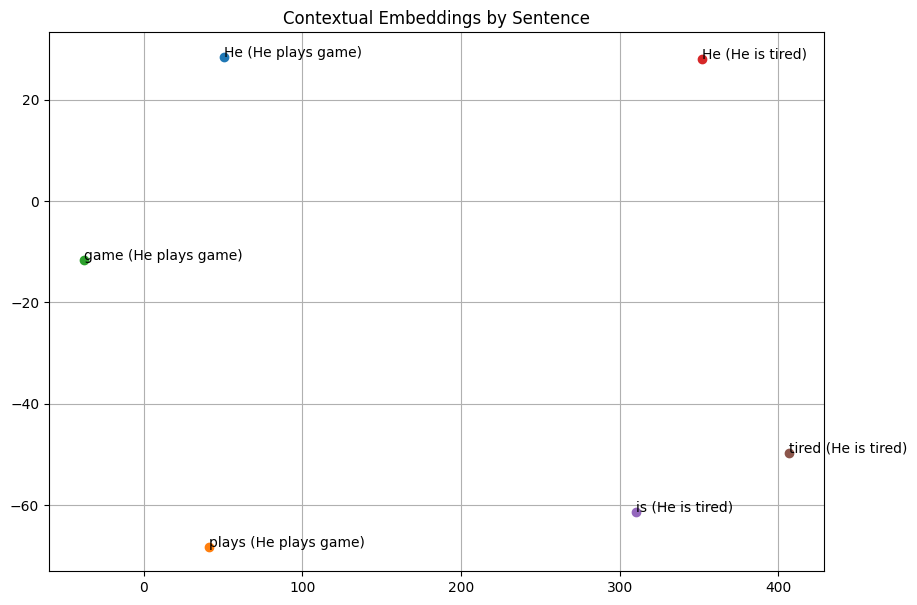

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd35ca4e500>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd48667ece0, execution_count=14 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd48667d960, raw_cell="sentences = ["He plays game", "He is tired"]
visua.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22566573736c227d/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X24sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [14]:
sentences = ["He plays game", "He is tired"]
visualize_contextual_embeddings(model, dataset.token2idx, sentences)